In [1]:
# generated by chatgtp

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt

2025-05-30 16:04:31.319052: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 16:04:31.395525: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 16:04:31.460947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748613871.516433 2422058 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748613871.533329 2422058 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748613871.657160 2422058 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

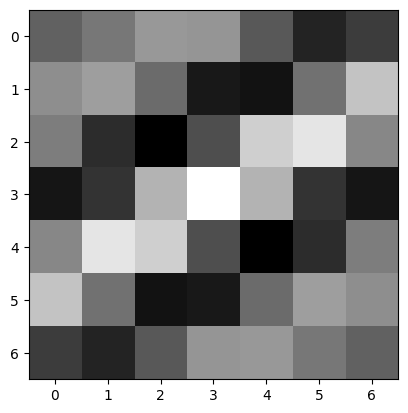

In [12]:
plt.imshow(filters[:,:,0,1], cmap='gray')

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8379 - loss: 0.6860 - val_accuracy: 0.9705 - val_loss: 0.1164
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9641 - loss: 0.1276 - val_accuracy: 0.9735 - val_loss: 0.0910
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9722 - loss: 0.0914 - val_accuracy: 0.9750 - val_loss: 0.0812
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9764 - loss: 0.0812 - val_accuracy: 0.9760 - val_loss: 0.0796
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9802 - loss: 0.0675 - val_accuracy: 0.9763 - val_loss: 0.0761
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9684 - loss: 0.0995
Test accuracy: 97.47%


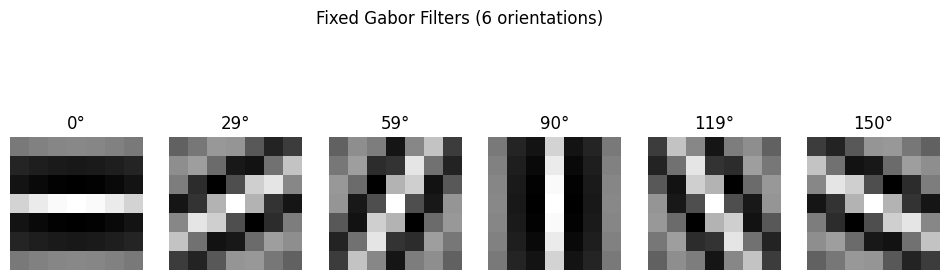

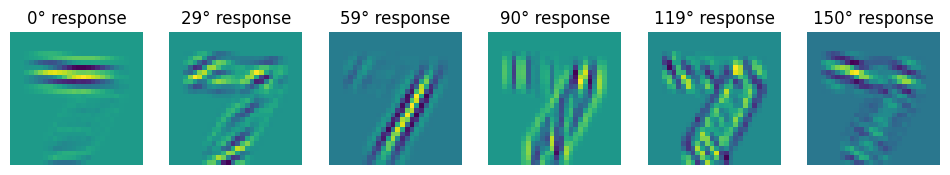

In [ ]:

# --- 1. Create Gabor-like filters rotated by multiples of 30 degrees ---

def gabor_kernel(size=7, sigma=2.0, Lambda=3.0, psi=0, gamma=0.5, theta=0):
    """Generate a 2D Gabor filter kernel."""
    half = size // 2
    y, x = np.meshgrid(range(-half, half+1), range(-half, half+1))
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * x_theta / Lambda + psi)
    return gb

# Generate 6 filters rotated by 0°, 30°, 60°, 90°, 120°, 150°
angles = np.deg2rad(np.arange(0, 180, 30))
filters = np.stack([gabor_kernel(theta=angle) for angle in angles], axis=-1)  # shape (size, size, 6)

# Conv2D weights shape: (kernel_h, kernel_w, input_channels, output_channels)
filters = filters[:, :, np.newaxis, :]  # add input channel dim = 1

# Normalize filters to zero mean and unit norm (optional)
filters -= filters.mean(axis=(0,1), keepdims=True)
filters /= np.linalg.norm(filters, axis=(0,1), keepdims=True) + 1e-10

# --- 2. Load MNIST data ---

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# --- 3. Build model with fixed Conv2D layer ---

# Create Conv2D layer instance (not called yet)
conv_layer = layers.Conv2D(
    filters=6,
    kernel_size=(7,7),
    padding='same',
    use_bias=False,
    trainable=False,
    input_shape=(28, 28, 1)
)

# Build the layer weights by calling build (necessary before setting weights)
conv_layer.build((None, 28, 28, 1))

# Set fixed filters as weights
conv_layer.set_weights([filters])

# Now use the layer in the model
inputs = layers.Input(shape=(28, 28, 1))
x = conv_layer(inputs)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- 4. Train the model ---

model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

# --- 5. Evaluate ---

loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {acc*100:.2f}%")

# --- 6. Visualize filters and example feature maps ---

plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(filters[:, :, 0, i], cmap='gray')
    plt.title(f"{int(np.rad2deg(angles[i]))}°")
    plt.axis('off')
plt.suptitle("Fixed Gabor Filters (6 orientations)")
plt.show()

# Show feature maps for a sample image
sample_img = x_test[0:1]
feature_maps = tf.nn.conv2d(sample_img, filters, strides=1, padding='SAME')

plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()


In [31]:
type(x_test[0:1])

numpy.ndarray

In [40]:
test = np.expand_dims(x_test[6], axis=0)

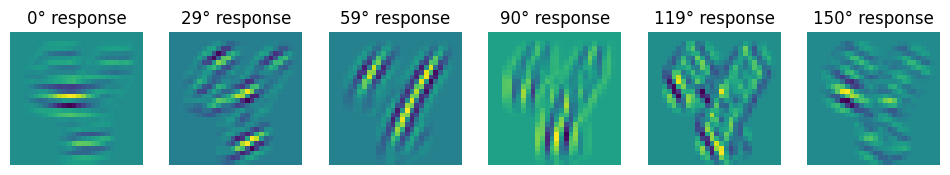

In [42]:
# Show feature maps for a sample image
sample_img = test
feature_maps = tf.nn.conv2d(sample_img, filters, strides=1, padding='SAME')

plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.title(f"{int(np.rad2deg(angles[i]))}° response")
    plt.axis('off')
plt.show()

In [43]:
feature_maps.shape

TensorShape([1, 28, 28, 6])